# Validation: CM Prior sensitivity

This notebook:

* loads a library defined model. 
* loads the data according to the data preprocessor class.
* Tests the effect of different CM priors on the CM effectiveness

In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
### Initial imports
import logging
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as T
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from epimodel.pymc3_models.utils import geom_convolution
from epimodel.pymc3_models import cm_effect
from epimodel.pymc3_models.cm_effect.datapreprocessor import DataPreprocessor


%matplotlib inline

INFO:epimodel.regions:Name index has 7 potential conflicts: ['american samoa', 'georgia', 'guam', 'northern mariana islands', 'puerto rico', 'united states minor outlying islands', 'virgin islands (u.s.)']
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:
Countermeasures                               min   ... mean  ... max   ... unique
 1 Masks over 60                              0.000 ... 0.016 ... 1.000 ... [0. 1.]
 2 Asymptomatic contact isolation             0.000 ... 0.120 ... 1.000 ... [0. 1.]
 3 Gatherings limited to 10                   0.000 ... 0.153 ... 1.000 ... [0. 1.]
 4 Gatherings limited to 100                  0.000 ... 0.248 ... 1.000 ... [0. 1.]
 5 Gatherings limited to 1000                 0.000 ... 0.285 ... 1.000 ... [0. 1.]
 6 Business suspended - some                  0.000 ... 0.283 ... 1.000 ... [0. 1.]
 7 Business suspended - many                  0.000 ... 0.206 ... 1.000 ... [0. 1.]
 8 Schools and universities closed            0.000 ... 0.359 ... 1.

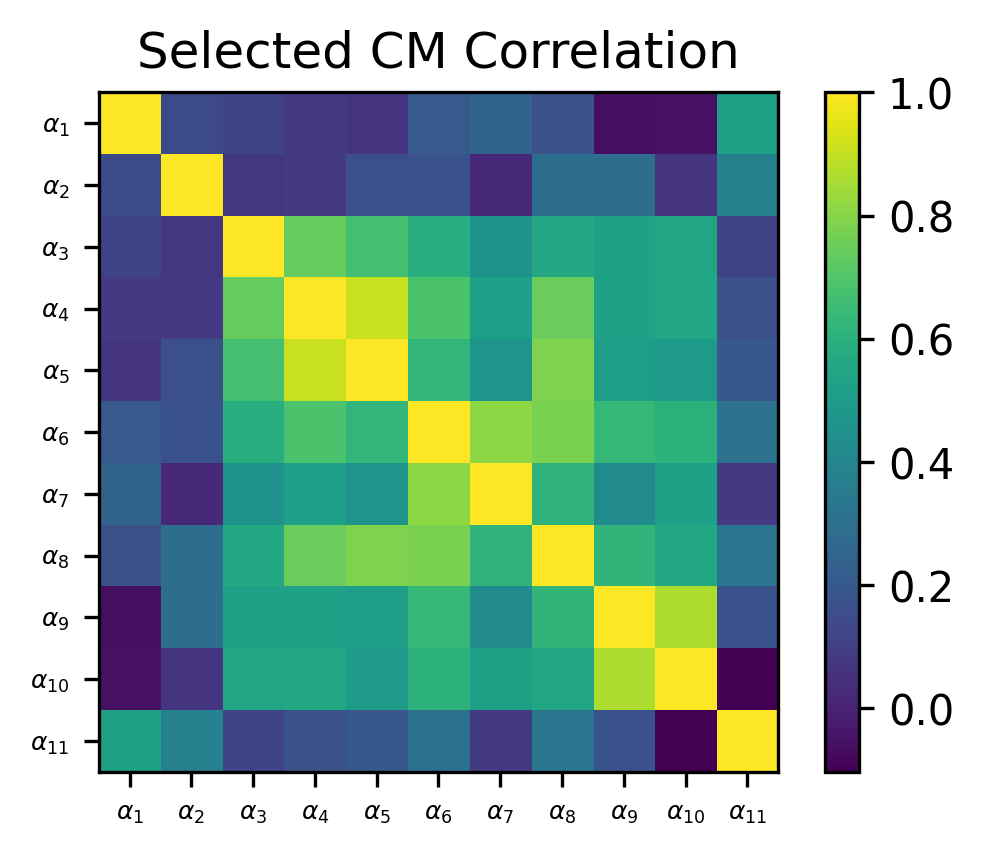

INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Data Preprocessing Complete using:

{
    "start_date": "2020-2-10",
    "end_date": "2020-04-05",
    "min_final_num_active_cases": 100,
    "min_num_active_mask": 10,
    "min_num_confirmed_mask": 10
}
Selected 35 Regions: f['AD', 'AT', 'BA', 'BE', 'BG', 'CH', 'CZ', 'DE', 'DK', 'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GR', 'HR', 'HU', 'IE', 'IL', 'IS', 'IT', 'JP', 'KR', 'LT', 'MX', 'NL', 'PL', 'RO', 'RS', 'RU', 'SE', 'SG', 'SI', 'SK']


In [7]:
regions = ['AT', 'BA', 'BE', 'BG', 'CH', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GB', 'GR', 'HR', 'HU', 'IE', 'IS', 'IT', 'LT', 'NL', 'PL', 'RO', 'RS', 'RU', 'SE', 'SI', 'SK']
# Same, outside Europe
regions += ['AD', 'CN-HK', 'EG', 'IL', 'JP', 'KR', 'MX', 'SG']


features = ['Masks over 60',
 'Asymptomatic contact isolation',
 'Gatherings limited to 10',
 'Gatherings limited to 100',
 'Gatherings limited to 1000',
 'Business suspended - some',
 'Business suspended - many',
 'Schools and universities closed',
 'General curfew - permissive',
 'General curfew - strict',
 'Healthcare specialisation over 0.2']

dp = DataPreprocessor()
data = dp.preprocess_data("../../data", regions, features)

In [15]:
priors = ['default', 'wide', 'wider', 'flat', 'vague'] 
models = []
for prior in priors:
    with cm_effect.models.CMModelFlexibleV3p1(data) as model:
        if prior=='default':
            model.build_cm_reduction_exp_gamma_prior()
        if prior=='wide':
            model.CM_Alpha = pm.Normal("CM_Alpha", 0.5, 10, shape=(model.nCMs,))
            model.Det("CMReduction", T.exp((-1.0) * model.CM_Alpha))
        if prior=='wider':
            model.CM_Alpha = pm.Normal("CM_Alpha", 0.5, 100, shape=(model.nCMs,))
            model.Det("CMReduction", T.exp((-1.0) * model.CM_Alpha))
        if prior=='vague':
            model.build_cm_reduction_exp_gamma_prior(alpha= 0.001, beta= 0.001) 
        if prior=='flat':
            model.CM_Alpha = pm.Flat("CM_Alpha", shape=(model.nCMs,))
            model.Det("CMReduction", T.exp((-1.0) * model.CM_Alpha))
        model.build_region_reliability_prior()
        model.build_region_growth_prior()
        model.build_rates()
        model.build_output_model()
    model.run(2000)
    models.append(model)


/Users/annie/anaconda/envs/py38/lib/python3.8/site-packages/pymc3/model.py:1430: ImputationWarning: Data in Observed_log contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...


CM_Alpha_log__               -76.07
RegionNoiseScale              72.69
RegionGrowthRate_log           9.98
Growth                      2711.95
InitialSize_log             -112.75
Observed_log_missing           0.00
Observed_log           -12061196.34
Name: Log-probability of test_point, dtype: float64


Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Observed_log_missing, InitialSize_log, Growth, RegionGrowthRate_log, RegionNoiseScale, CM_Alpha]
INFO:pymc3:NUTS: [Observed_log_missing, InitialSize_log, Growth, RegionGrowthRate_log, RegionNoiseScale, CM_Alpha]
Sampling 2 chains, 3,998 divergences: 100%|██████████| 5000/5000 [08:08<00:00, 10.23draws/s]
There were 1997 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 1997 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.2529914194152473, but should be close to 0.8. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
ERROR:pymc3:The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.5174914134545847, but s

### Plot traces 

In [ ]:
for model in models:
    model.plot_traces()

### Plot countermeasure effectiveness

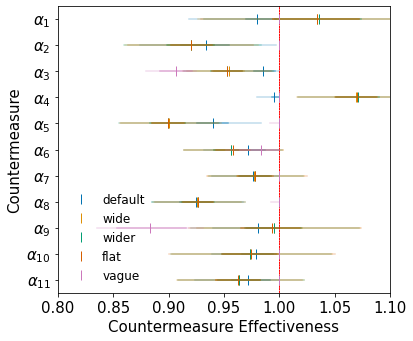

In [17]:
fig = plt.figure(figsize=(6, 5))
colors = sns.color_palette("colorblind")

for i in range(len(models)):
        means = np.mean(models[i].trace["CMReduction"], axis=0)
        li = np.percentile(models[i].trace["CMReduction"], 2.5, axis=0)
        ui = np.percentile(models[i].trace["CMReduction"], 97.5, axis=0)
        lq = np.percentile(models[i].trace["CMReduction"], 25, axis=0)
        uq = np.percentile(models[i].trace["CMReduction"], 75, axis=0)
        N_cms = means.size
        
        plt.plot([1, 1], [1, -(N_cms)], "--r", linewidth=0.5)
        y_vals = -1 * np.arange(N_cms)
        plt.plot(means, y_vals, marker="|", markersize=10, color=colors[i], label = priors[i],
                 linewidth=0)
        for cm in range(N_cms):
            plt.plot([li[cm], ui[cm]], [y_vals[cm], y_vals[cm]], color=colors[i], alpha=0.25)
            plt.plot([lq[cm], uq[cm]], [y_vals[cm], y_vals[cm]], color=colors[i], alpha=0.5)

plt.xlim([0.8, 1.1])
plt.rc('font', size=15)
plt.ylim([-(N_cms - 0.5), 0.5])
plt.ylabel("Countermeasure", rotation=90)
plt.yticks(y_vals, [f"$\\alpha_{{{i + 1}}}$" for i in range(N_cms)])
plt.xlabel("Countermeasure Effectiveness")
plt.tight_layout()
plt.legend(frameon=False, fontsize=12)
plt.savefig('out/cm_prior_sensitivity.pdf')